# Falls Processing

In this notebook, I will process and perform exploratory analysis on the Medicare falls data. 

In [103]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc

In [66]:
#we have yearly (quarterly), monthly, and weekly counts of falls by county 

#start with year (least granular)

yearly_falls = pd.read_csv("thesis_falls_counts/final_falls_count_quarter.csv")

In [56]:
#state code, county code (is that FIPS?), year, quarter number, count 
yearly_falls.head(10)

,STATE_CODE,COUNTY_CD,year,quarter,quarter_count
0,1,0,2005,1,<11
1,1,0,2005,2,<11
2,1,0,2005,3,<11
3,1,0,2005,4,<11
4,1,0,2006,1,<11
5,1,0,2006,2,<11
6,1,0,2006,3,<11
7,1,0,2009,1,<11
8,1,0,2009,2,<11
9,1,0,2009,3,18


In [57]:
len(yearly_falls)

108051

In [58]:
#how many years? 2005 - 2015
print(len(yearly_falls['year'].unique())) 
yearly_falls['year'].describe()

11


count    108051.000000
mean       2010.861464
std           2.882161
min        2005.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2015.000000
Name: year, dtype: float64

In [59]:
#how many missing values? 
len(yearly_falls[yearly_falls['quarter_count']=='<11'])

53337

In [60]:
#what percentage missing? 
len(yearly_falls[yearly_falls['quarter_count']=='<11']) / len(yearly_falls)

0.493628008995752

In [40]:
#The state and county codes are SSA codes 
#https://www.nber.org/research/data/ssa-federal-information-processing-series-fips-state-and-county-crosswalk
#we need to combine together and then link to FIPS codes 
#state code + 3 digit county code


def ssa_county_codes(x): 
    """
    Create three digit SSA county codes
    """
    
    if x < 9: 
        return '00'+str(x)
    elif x > 9 and x < 100: 
        return '0' + str(x)
    elif x >= 100 and x < 1000: 
        return str(x)
    

In [64]:
#data preprocessing and cleaning for the data 
#does not have separate fips county merging by year right now 

def yearly_clean_data(falls_df, count_column, fips_df): 
    """
    Cleans falls Medicare data for easier analysis
    Inputs: 
        falls_df: dataframe with medicare data 
        count_column (str): name of count column
        fips_df: crosswalk for ssa to fips
    """
    
    #replace missing values 
    falls_df[count_column] = falls_df[count_column].mask(falls_df[count_column] == '<11', np.nan)
    falls_df[count_column]=falls_df[count_column].astype(float)
    
    
    #drop noncontinguous states: AK, HI, Puetro Rico
    stateToRemove = [2, 12, 40]
    falls_df = falls_df[~falls_df.STATE_CODE.isin(stateToRemove)]
    
    #create SSA county codes
    falls_df['3_county'] = falls_df['COUNTY_CD'].apply(ssa_county_codes)
    falls_df['str_state'] = falls_df['STATE_CODE'].apply(lambda x: str(x))
    falls_df['ssacounty'] = falls_df['str_state'] + falls_df['3_county']
    falls_df['ssacounty']=falls_df['ssacounty'].astype(float)

    #merge to get FIPS 
    ssa_fips_codes = fips_df[['ssacounty', 'fipscounty']]
    
    #only want SSA codes that also have fips counties, even if we lose a little data
    clean_falls = falls_df.merge(ssa_fips_codes, how ='inner', left_on = "ssacounty", right_on = 'ssacounty')
    
    #rename quarter to months for this function to work 
    clean_falls.rename(columns={'quarter': 'month'}, inplace=True)
    
    
    
    #clean dates - treat quarter as month 
    clean_falls['date'] = pd.to_datetime(clean_falls[['year','month']].assign(day=1)).dt.to_period('M')
    
    #cut down to correct window
    short_clean_falls = clean_falls[clean_falls['date'] >= '2009-03']
    short_clean_falls = short_clean_falls[short_clean_falls['date'] <= '2015-03'] 
    
    
    #remove extra vars 
    short_clean_falls.drop(['3_county', 'str_state', 'ssacounty', 'STATE_CODE', 'COUNTY_CD',  'year', 'month'], axis = 1, inplace = True)
    
   
    return short_clean_falls
    

In [67]:
clean_year = yearly_clean_data(yearly_falls, 'quarter_count', fips_crosswalk_2015)

/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_12823/3141091255.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falls_df['3_county'] = falls_df['COUNTY_CD'].apply(ssa_county_codes)
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_12823/3141091255.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falls_df['str_state'] = falls_df['STATE_CODE'].apply(lambda x: str(x))
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_12823/3141091255.py:25: SettingWithCopyWarning: 
A valu

In [68]:
#reset index and drop duplicates
clean_year.set_index(['fipscounty', 'date'], inplace=True)
unique_year_falls = clean_year[~clean_year.index.duplicated(keep='first')]
    

In [69]:
clean_year.head()

quarter_count
fipscounty date                  
1001       2009-03           18.0
           2009-04           21.0
           2010-01           28.0
           2010-02           15.0
           2010-03           35.0

In [70]:
clean_year['quarter_count'].sum()

3903373.0

In [48]:
#now we want to link SSA codes to FIPS codes 
#the codes might change slightly for different years 
#for 2003 - 2011 one csv
#2012 - 2015 are all individual csvs
#let's just use the 2015 one 

fips_crosswalk_2015 = pd.read_csv("ssa_fips_state_county2015_nostatewide.csv")

In [49]:
fips_crosswalk_2015.head()

,county,state,ssacounty,fipscounty,cbsaold,cbsanameold,cbsa,cbsaname,ssastate,fipsstate
0,AUTAUGA,AL,1000,1001,33860.0,"Montgomery, AL",33860.0,"Montgomery, AL",1,1
1,BALDWIN,AL,1010,1003,NaN,NaN,19300.0,"Daphne-Fairhope-Foley, AL",1,1
2,BARBOUR,AL,1020,1005,NaN,NaN,NaN,NaN,1,1
3,BIBB,AL,1030,1007,13820.0,"Birmingham-Hoover, AL",13820.0,"Birmingham-Hoover, AL",1,1
4,BLOUNT,AL,1040,1009,13820.0,"Birmingham-Hoover, AL",13820.0,"Birmingham-Hoover, AL",1,1


In [99]:
len(clean_year['fipscounty'].unique())

3245

In [100]:
clean_year.head()

,STATE_CODE,COUNTY_CD,year,quarter,quarter_count,fipscounty
0,1,0,2005,1,NaN,1001.0
1,1,0,2005,2,NaN,1001.0
2,1,0,2005,3,NaN,1001.0
3,1,0,2005,4,NaN,1001.0
4,1,0,2006,1,NaN,1001.0


In [103]:
grouped_falls.head()

Falls_Num
fipscounty year           
1001.0     2005        0.0
           2006        0.0
           2009       39.0
           2010      109.0
           2011      113.0

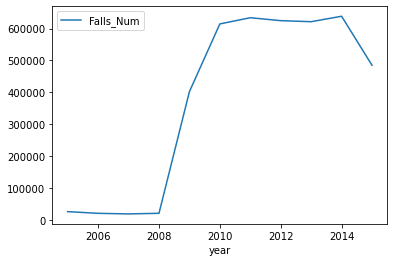

In [84]:
#this looks like a data problem 
#might need to look at after 2008 
#maybe 2009/10 - 2015? 
grouped_falls.groupby(['year']).sum().plot();

In [93]:
grouped_falls.columns

Index(['Falls_Num'], dtype='object')

In [116]:
#what does missingness look like by year?
falls_to_plot['quarter_count'].isna().groupby(falls_to_plot['year'], sort=False).sum().reset_index()

,year,quarter_count
0,2005,5145
1,2006,4769
2,2009,6171
3,2010,4638
4,2011,4585
5,2012,4666
6,2013,4722
7,2014,4616
8,2015,5106
9,2007,4492


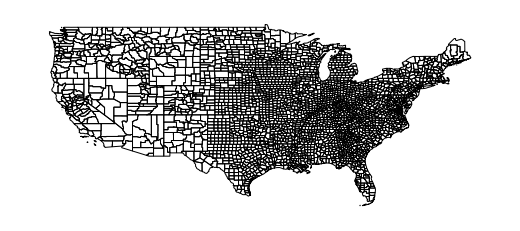

In [3]:
# plotting 
#https://python-graph-gallery.com/choropleth-map-geopandas-python

# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

# Basic plot with just county outlines
gplt.polyplot(geoData, figsize=(20, 4));

In [124]:
#now let's just look at overall counts of falls by county for the entire time period 
#clean_year.head()
clean_year_only_counts = clean_year[['quarter_count', 'fipscounty']]
total_counts = clean_year_only_counts.groupby(['fipscounty']).sum()

In [125]:
total_counts.head()

,quarter_count
fipscounty,
1001.0,656.0
1003.0,3111.0
1005.0,307.0
1007.0,151.0
1009.0,517.0


In [128]:
plot_data = geoData.merge(total_counts, left_on=['id'], right_on=['fipscounty'])

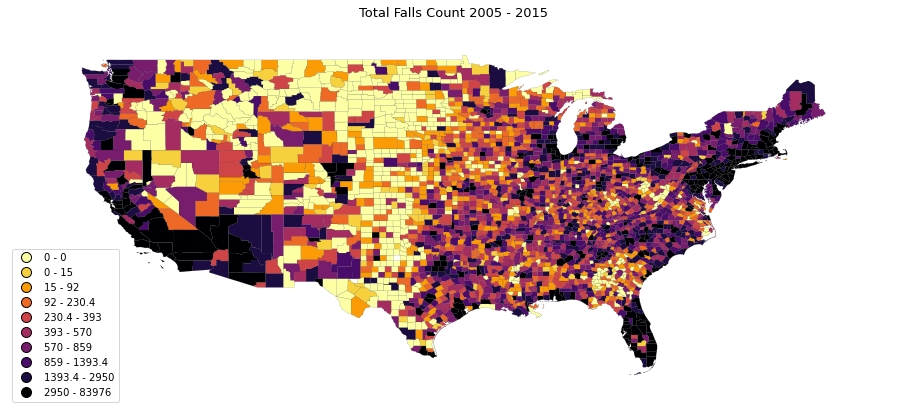

In [131]:
# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(plot_data['quarter_count'], k=10)

# Map
gplt.choropleth(plot_data, 
    hue="quarter_count", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

ax.set_title('Total Falls Count 2005 - 2015', fontsize=13);

In [170]:
quarters_df = clean_year.drop(['STATE_CODE', 'COUNTY_CD', 'year'], axis =1)

In [172]:
quarters_df.head()

,quarter,quarter_count,fipscounty
0,1,NaN,1001.0
1,2,NaN,1001.0
2,3,NaN,1001.0
3,4,NaN,1001.0
4,1,NaN,1001.0


In [174]:
winter_quarter = quarters_df[quarters_df['quarter'] == 1] 
spring_quarter = quarters_df[quarters_df['quarter'] == 2] 
summer_quarter = quarters_df[quarters_df['quarter'] == 3] 
fall_quarter = quarters_df[quarters_df['quarter'] == 4] 

In [178]:
winter_quarter = winter_quarter.groupby(['fipscounty']).sum()

In [179]:
winter_quarter.head()

,quarter,quarter_count
fipscounty,,
1001.0,9,175.0
1003.0,11,816.0
1005.0,8,107.0
1007.0,8,44.0
1009.0,9,116.0


In [182]:
summer_quarter = summer_quarter.groupby(['fipscounty']).sum()

/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)


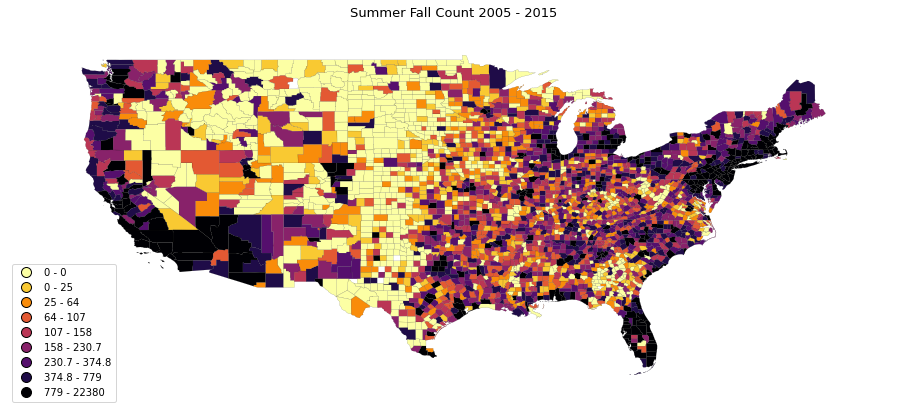

In [183]:
summer_plot = geoData.merge(summer_quarter, left_on=['id'], right_on=['fipscounty'])

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
scheme = mc.Quantiles(summer_plot['quarter_count'], k=10)

# Map
gplt.choropleth(summer_plot, 
    hue="quarter_count", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

ax.set_title('Summer Fall Count 2005 - 2015', fontsize=13);

## Monthly Data

In [50]:
#monthly data 
monthly_falls = pd.read_csv("thesis_falls_counts/final_falls_count_month.csv")

In [51]:
monthly_falls.head()

,STATE_CODE,COUNTY_CD,month,month_count,year,quarter
0,1,0,1,<11,2005,1
1,1,0,1,<11,2006,1
2,1,0,1,<11,2009,1
3,1,0,1,<11,2010,1
4,1,0,1,14,2011,1


In [10]:
len(monthly_falls)
#70% missingness - yikes. 
len(monthly_falls[monthly_falls['month_count']=='<11']) / len(monthly_falls)

0.7086154788570754

In [ ]:
fips_crosswalk_2015 = pd.read_csv("ssa_fips_state_county2015_nostatewide.csv")

In [85]:
#The state and county codes are SSA codes 
#https://www.nber.org/research/data/ssa-federal-information-processing-series-fips-state-and-county-crosswalk
#we need to combine together and then link to FIPS codes 
#state code + 3 digit county code


def ssa_county_codes(x): 
    """
    Create three digit SSA county codes
    """
    
    if x < 9: 
        return '00'+str(x)
    elif x > 9 and x < 100: 
        return '0' + str(x)
    elif x >= 100 and x < 1000: 
        return str(x)
    
#data preprocessing and cleaning for the data 
#does not have separate fips county merging by year right now 

def monthly_clean_data(falls_df, count_column, fips_df): 
    """
    Cleans falls Medicare data for easier analysis
    Inputs: 
        falls_df: dataframe with medicare data 
        count_column (str): name of count column
        fips_df: crosswalk for ssa to fips
    """
    
    #replace missing values 
    falls_df[count_column] = falls_df[count_column].mask(falls_df[count_column] == '<11', np.nan)
    falls_df[count_column]=falls_df[count_column].astype(float)
    
    
    #drop noncontinguous states: AK, HI, Puetro Rico
    stateToRemove = [2, 12, 40]
    falls_df = falls_df[~falls_df.STATE_CODE.isin(stateToRemove)]
    
    #create SSA county codes
    falls_df['3_county'] = falls_df['COUNTY_CD'].apply(ssa_county_codes)
    falls_df['str_state'] = falls_df['STATE_CODE'].apply(lambda x: str(x))
    falls_df['ssacounty'] = falls_df['str_state'] + falls_df['3_county']
    falls_df['ssacounty']=falls_df['ssacounty'].astype(float)

    #merge to get FIPS 
    ssa_fips_codes = fips_df[['ssacounty', 'fipscounty']]
    
    #only want SSA codes that also have fips counties, even if we lose a little data
    clean_falls = falls_df.merge(ssa_fips_codes, how ='inner', left_on = "ssacounty", right_on = 'ssacounty')
    
    #clean dates 
    clean_falls['date'] = pd.to_datetime(clean_falls[['year','month']].assign(day=1)).dt.to_period('M')
    
    #cut down to correct window
    short_clean_falls = clean_falls[(clean_falls['date'] >= '2009-07') & (clean_falls['date'] <= '2015-07')]    
    
    #remove extra vars 
    short_clean_falls.drop(['3_county', 'str_state', 'ssacounty', 'STATE_CODE', 'COUNTY_CD', 'month', 'year', 'quarter'], axis = 1, inplace = True)
    
   
    return short_clean_falls
    

# clean_month = monthly_clean_data(monthly_falls, 'month_count', fips_crosswalk_2015)

In [87]:
clean_month.head()

,month_count,fipscounty,date
3,NaN,1001,2010-01
4,14.0,1001,2011-01
5,NaN,1001,2012-01
6,NaN,1001,2013-01
7,NaN,1001,2014-01


In [58]:
len(clean_month)

205544

In [56]:
#how many unique counties
#problem solved! same as geodata now
len(clean_month['fipscounty'].unique())

3107

In [55]:
clean_month.to_csv("medicare_monthly_falls.csv", index=False)

In [90]:
def grouped_county_df(df):
    """
    Groups number of falls by county, multiple index
    """
    #reset index and drop duplicates
    grouped_df = df.set_index(['fipscounty', 'date'], inplace=False)
    unique_month_falls = grouped_df[~grouped_df.index.duplicated(keep='first')]
    return unique_month_falls

In [91]:
unique_month_falls = grouped_county_df(clean_month)

In [92]:
len(unique_month_falls)

205471

# unique_month_falls['month_count'].groupby(['date']).sum().plot();

In [81]:
unique_month_falls['month_count'].sum()

3374875.0

In [105]:
def plot_fall_counts(grouped_df, US_map, title): 
    """
    Plots the grouped_df on a US_map from GeoData
    """
    total_month_counts = grouped_df.groupby(['fipscounty']).sum()
    plot_data = US_map.merge(total_month_counts, left_on=['id'], right_on=['fipscounty'])
    
    
    
    #plot 
    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Set up the color sheme:
    scheme = mc.Quantiles(plot_data['month_count'], k=10)

    # Map
    gplt.choropleth(plot_data, 
        hue="month_count", 
        linewidth=.1,
        scheme=scheme, cmap='Greens',
        legend=True,
        edgecolor='black',
        ax=ax
    );

    ax.set_title(title, fontsize=13);

    

In [276]:
total_month_counts = unique_month_falls.groupby(['fipscounty']).sum()

In [279]:
plot_data = geoData.merge(total_month_counts, left_on=['id'], right_on=['fipscounty'])


In [280]:
plot_data.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,month_count
0,1001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",299.0
1,1009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",60.0
2,1017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772...",384.0
3,1021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",22.0
4,1033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587...",1167.0


/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


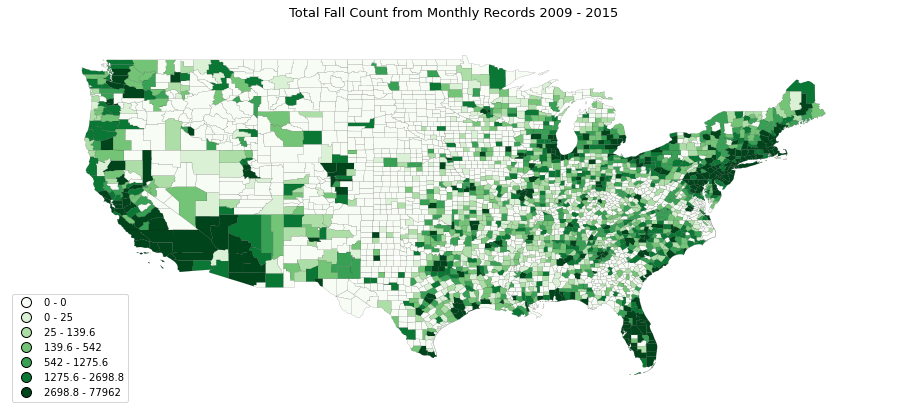

In [106]:
plot_fall_counts(unique_month_falls, geoData, 'Total Fall Count from Monthly Records 2009 - 2015')

In [82]:
clean_month.head()

,month_count,fipscounty,date
3,NaN,1001,2010-01
4,14.0,1001,2011-01
5,NaN,1001,2012-01
6,NaN,1001,2013-01
7,NaN,1001,2014-01


/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 6
  Warn("Warning: setting k to %d" % k_q, UserWarning)


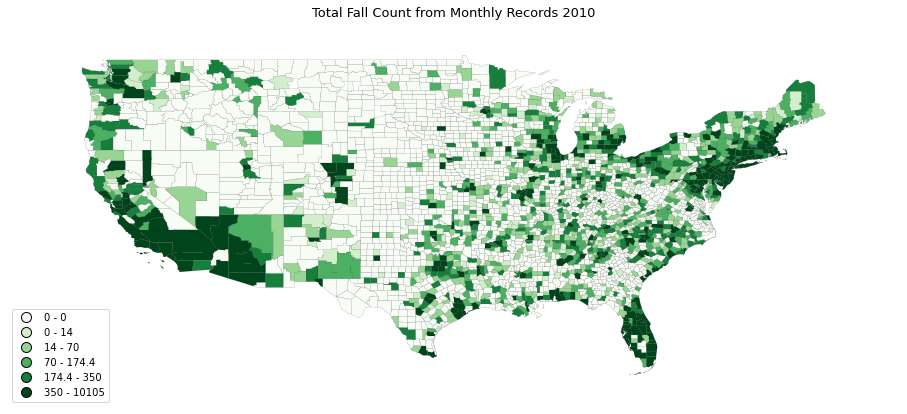

In [107]:
#2010
month_2010 = clean_month[(clean_month['date'] > '2010-01') & (clean_month['date'] < '2010-12')]
grouped_2010 = grouped_county_df(month_2010)
plot_fall_counts(grouped_2010, geoData, 'Total Fall Count from Monthly Records 2010')

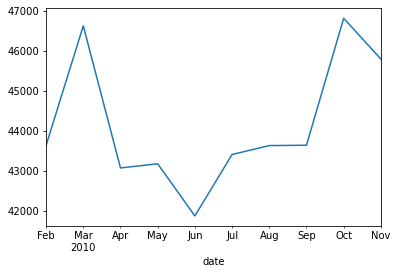

In [109]:
grouped_2010['month_count'].groupby(['date']).sum().plot();

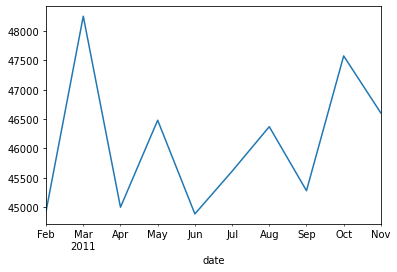

In [110]:
#2011
month_2011 = clean_month[(clean_month['date'] > '2011-01') & (clean_month['date'] < '2011-12')]
grouped_2011 = grouped_county_df(month_2011)
grouped_2011['month_count'].groupby(['date']).sum().plot();

/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 6
  Warn("Warning: setting k to %d" % k_q, UserWarning)


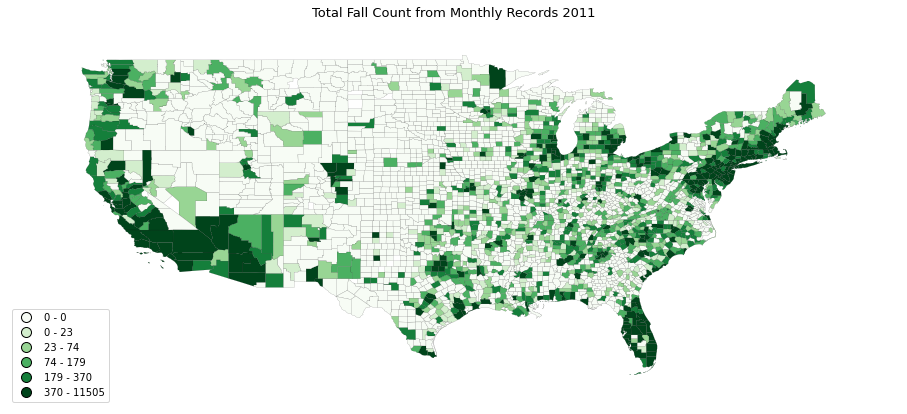

In [126]:
plot_fall_counts(grouped_2011, geoData, 'Total Fall Count from Monthly Records 2011')

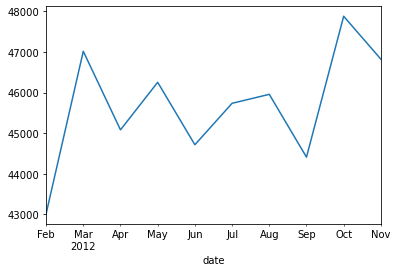

In [125]:
#2012
month_2012 = clean_month[(clean_month['date'] > '2012-01') & (clean_month['date'] < '2012-12')]
grouped_2012 = grouped_county_df(month_2012)
grouped_2012['month_count'].groupby(['date']).sum().plot();

In [ ]:
plot_fall_counts(grouped_2012, geoData, 'Total Fall Count from Monthly Records 2012')

## Weekly Records

In [112]:
weekly_falls = pd.read_csv("thesis_falls_counts/final_falls_count_week.csv")

In [113]:
weekly_falls.head()

,STATE_CODE,COUNTY_CD,week,week_count,year
0,1,0,1,<11,2009
1,1,0,1,<11,2011
2,1,0,1,<11,2012
3,1,0,1,<11,2013
4,1,0,1,<11,2014


In [305]:
#https://stackoverflow.com/questions/22789198/converting-week-numbers-to-dates

In [177]:
#data preprocessing and cleaning for the data 
#does not have separate fips county merging by year right now 

def weekly_clean_data(falls_df, count_column, fips_df): 
    """
    Cleans falls Medicare data for easier analysis
    Inputs: 
        falls_df: dataframe with medicare data 
        count_column (str): name of count column
        fips_df: crosswalk for ssa to fips
    """
    
    #replace missing values 
    falls_df[count_column] = falls_df[count_column].mask(falls_df[count_column] == '<11', np.nan)
    falls_df[count_column]=falls_df[count_column].astype(float)
    
    
    #drop noncontinguous states: AK, HI, Puetro Rico
    stateToRemove = [2, 12, 40]
    falls_df = falls_df[~falls_df.STATE_CODE.isin(stateToRemove)]
    
    #create SSA county codes
    falls_df['3_county'] = falls_df['COUNTY_CD'].apply(ssa_county_codes)
    falls_df['str_state'] = falls_df['STATE_CODE'].apply(lambda x: str(x))
    falls_df['ssacounty'] = falls_df['str_state'] + falls_df['3_county']
    falls_df['ssacounty']=falls_df['ssacounty'].astype(float)

    #merge to get FIPS 
    ssa_fips_codes = fips_df[['ssacounty', 'fipscounty']]
    
    #only want SSA codes that also have fips counties, even if we lose a little data
    clean_falls = falls_df.merge(ssa_fips_codes, how ='inner', left_on = "ssacounty", right_on = 'ssacounty')
    
    
    #create week number - year key 
    clean_falls['year-week'] = clean_falls['week'].astype(str) + '-' + clean_falls['year'].astype(str)

    
    #cut down to correct window
    #https://www.datecalculator.org/
    #july 1st, 2009 and 2015 happened in 27th week 
    short_clean_falls = clean_falls[(clean_falls['year-week'] >= '27-2009') & (clean_falls['year-week'] >= '27-2015')]    
    
    #remove extra vars 
    short_clean_falls.drop(['3_county', 'str_state', 'ssacounty', 'STATE_CODE', 'COUNTY_CD'], axis = 1, inplace = True)
    
   
   
    return short_clean_falls
    

In [178]:
fips_weeks = weekly_clean_data(weekly_falls, 'week_count', fips_crosswalk_2015)

/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_12823/2079167091.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falls_df['3_county'] = falls_df['COUNTY_CD'].apply(ssa_county_codes)
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_12823/2079167091.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falls_df['str_state'] = falls_df['STATE_CODE'].apply(lambda x: str(x))
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_12823/2079167091.py:25: SettingWithCopyWarning: 
A valu

In [179]:
fips_weeks.head()

,week,week_count,year,fipscounty,year-week
12,3,NaN,2005,1001,3-2005
13,3,NaN,2010,1001,3-2010
14,3,NaN,2011,1001,3-2011
15,3,NaN,2013,1001,3-2013
16,3,NaN,2015,1001,3-2015


In [189]:
fips_weeks['week_count'].sum()

1533516.0

In [180]:
def weekly_grouped_county_df(df):
    """
    Groups number of falls by county, multiple index
    """
    #reset index and drop duplicates
    grouped_df = df.set_index(['fipscounty', 'year-week'], inplace=False)
    unique_month_falls = grouped_df[~grouped_df.index.duplicated(keep='first')]
    return unique_month_falls

In [181]:
grouped_weekly = weekly_grouped_county_df(fips_weeks)

In [182]:
grouped_weekly.head()

week  week_count  year
fipscounty year-week                        
1001       3-2005        3         NaN  2005
           3-2010        3         NaN  2010
           3-2011        3         NaN  2011
           3-2013        3         NaN  2013
           3-2015        3         NaN  2015

In [183]:
grouped_weekly.drop(['week', 'year'], inplace = True, axis = 1)

In [184]:
grouped_weekly.head()

week_count
fipscounty year-week            
1001       3-2005            NaN
           3-2010            NaN
           3-2011            NaN
           3-2013            NaN
           3-2015            NaN

In [185]:
total_weekly_counts = grouped_weekly.groupby(['fipscounty']).sum()

In [186]:
total_weekly_counts.head()

,week_count
fipscounty,
1001,0.0
1003,630.0
1005,0.0
1007,0.0
1009,0.0


In [187]:
counties_over_1000 = total_weekly_counts[total_weekly_counts['week_count']>= 1000]

In [188]:
#275 counties with fall counts over 1,000 in the time frame
counties_over_1000

,week_count
fipscounty,
1073,5609.0
1089,2829.0
1097,2749.0
1101,1295.0
1125,1497.0
...,...
53077,1072.0
54039,1441.0
55025,3781.0


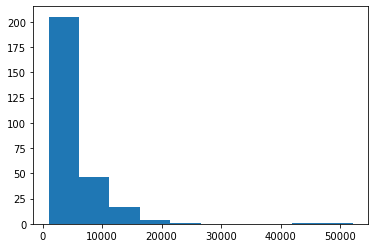

In [191]:
plt.hist(counties_over_1000);

In [193]:
sorted_1000_counties = counties_over_1000.sort_values(by = ['week_count'], ascending = False)

In [194]:
sorted_1000_counties.head(20)

,week_count
fipscounty,
17031,52170.0
6037,46650.0
4013,23645.0
48201,20469.0
12099,18879.0
26163,18596.0
25017,16895.0
12086,16075.0
36103,16028.0


In [317]:
import time 
import datetime
#this happens on full data frame 

def week_to_datetime(x): 
    atime = time.asctime(time.strptime('{} {} 1'.format(x[4], x[2]), '%Y %W %w'))
    print(atime)
    return atime 


fips_weeks.apply(week_to_datetime, axis=1)

Mon Jan  5 00:00:00 2009
Mon Jan  3 00:00:00 2011
Mon Jan  2 00:00:00 2012
Mon Jan  7 00:00:00 2013
Mon Jan  6 00:00:00 2014
Mon Jan  5 00:00:00 2015
Mon Jan 11 00:00:00 2010
Mon Jan 10 00:00:00 2011
Mon Jan  9 00:00:00 2012
Mon Jan 14 00:00:00 2013
Mon Jan 13 00:00:00 2014
Mon Jan 12 00:00:00 2015
Mon Jan 17 00:00:00 2005
Mon Jan 18 00:00:00 2010
Mon Jan 17 00:00:00 2011
Mon Jan 21 00:00:00 2013
Mon Jan 19 00:00:00 2015
Mon Jan 23 00:00:00 2006
Mon Jan 26 00:00:00 2009
Mon Jan 25 00:00:00 2010
Mon Jan 24 00:00:00 2011
Mon Jan 28 00:00:00 2013
Mon Jan 27 00:00:00 2014
Mon Jan 26 00:00:00 2015
Mon Jan 31 00:00:00 2005
Mon Feb  1 00:00:00 2010
Mon Feb  4 00:00:00 2013
Mon Feb  3 00:00:00 2014
Mon Feb  2 00:00:00 2015
Mon Feb  6 00:00:00 2006
Mon Feb  8 00:00:00 2010
Mon Feb  7 00:00:00 2011
Mon Feb  6 00:00:00 2012
Mon Feb 11 00:00:00 2013
Mon Feb 10 00:00:00 2014
Mon Feb  9 00:00:00 2015
Mon Feb 16 00:00:00 2009
Mon Feb 15 00:00:00 2010
Mon Feb 14 00:00:00 2011
Mon Feb 13 00:00:00 2012


ValueError: day of year out of range

In [ ]:
#clean dates 
    clean_falls['date'] = pd.to_datetime(clean_falls[['year','month']].assign(day=1)).dt.to_period('M')
    
    #cut down to correct window
    short_clean_falls = clean_falls[clean_falls['date'] >= '2009-07']
    short_clean_falls = short_clean_falls[short_clean_falls['date'] <= '2015-07'] 
    
    
    #remove extra vars 
    short_clean_falls.drop(['3_county', 'str_state', 'ssacounty', 'STATE_CODE', 'COUNTY_CD', 'month', 'year', 'quarter'], axis = 1, inplace = True)